# Learning large Bayesian Networks

A short introduction into Bayesian networks and an overview of techiques based on deep learning to mine them. With *large* we mean *many nodes*.

Author: Tobias Windisch (http://www.tobias-windisch.de)

In [15]:
from networkx import DiGraph
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

Before diving into Bayesian networks, let us start with a few basics:

## Conditional density distributions

Given random variables $X_1, X_2, \ldots, X_d$, then the **conditional density distribution** is

$$f_{X_1|X_2,\ldots,X_d}(x_1|x_2\ldots, x_d):=\frac{f_{X_1}(x_1)}{f_{X_2,\ldots, X_d}(x_2, \ldots, x_d)}$$

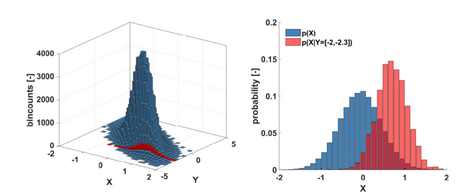


**Note**: For each selection $x_2,\ldots, x_n$ the function $f_{X_1|X_2,\ldots,x_n}(\cdot|x_2\ldots, x_n)$ is a density function on $\mathbb{R}$


### Example

$$f_{X_1|X_2, X_3} (\cdot | x_2, x_3)= \mathcal{N}(x_2, x_3^2)$$
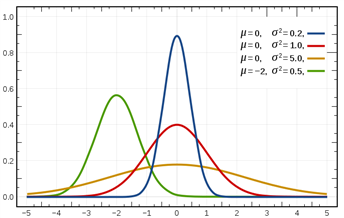

### Bayes rule
Given $f_{X_1|X_2,\ldots,X_d}$, one can compute:
$$\underbrace{f_{X_1}(x_1)}_{\mathbb{P}(A)} = \underbrace{f_{X_1|X_2,\ldots,X_d}(x_1|x_2\ldots, x_d)}_{\mathbb{P}(A|B)}\cdot \underbrace{f_{X_2,\ldots, X_d}(x_2, \ldots, x_d)}_{\mathbb{P}(B)}$$



## Whats a Bayesian network?

"Bayesian" does not relate to "Bayesian statistics", but more to the **Bayes rule**.

Let $X_1, \ldots, X_d$ random  variables on $\mathbb{R}^d$. To explain what a Bayesian network is, let us first explain its two ingredients, which are

* A directed acyclic graph whose nodes correspond to the random variables
* For each node of the graph a node model for for the conditional distribution of the respective variable


In more detail:

### Directed acyclic graphs (DAGs)

A DAG $G$ on $\{X_1,\ldots, X_d\}$ is a directed graph without directed cycles

In [2]:
import networkx as nx

In [3]:
small_dag = nx.DiGraph()
small_dag.add_edges_from(
    [
        ("$X_2$", "$X_3$"), ("$X_4$", "$X_1$"), ("$X_4$", "$X_3$"), ("$X_3$", "$X_5$"), ("$X_1$", "$X_5$")
    ])

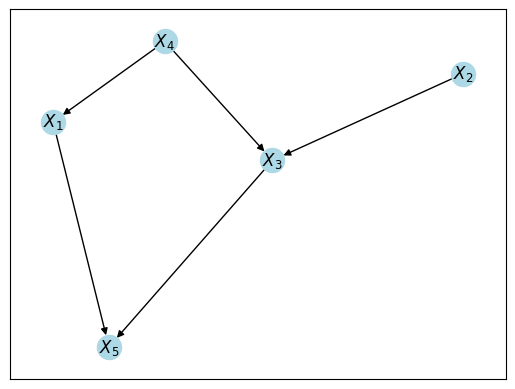

In [4]:
pos = nx.spring_layout(small_dag, seed=10)
nx.draw_networkx(small_dag, pos=pos, node_color='lightblue')

#### Parent of a node
For a node $i$, let $P_G(i)$ be its parent nodes (i.e, those nodes $j$ with directed edges into $i$)


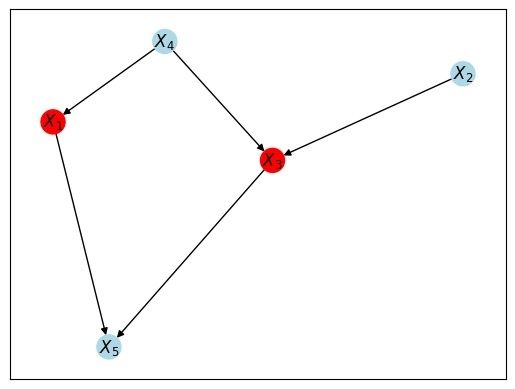

In [5]:
nx.draw_networkx(small_dag, pos=pos, node_color=['red' if n in ['$X_1$', '$X_3$'] else 'lightblue' for n in small_dag.nodes])

### Node functions
For each $i$, the conditional density function 
$$f_{X_i|P_G(X_i)}(\cdot|x_j: j\in P_G(i))$$

needs to be given. That is, the density function of $x_i$ given $(x_j: j\in P_G(i))$

For instance for the graph above:

* $f_{X_2}(x_2) \sim \mathcal{N}(0, 1)$
* $f_{X_4}(x_4) \sim \mathcal{N}(1, 0.5)$
* $f_{X_1|X_4}(x_1|x_4) \sim \mathcal{N}(x_4, x_4^2)$
* $f_{X_5|X_1, X_3}(x_5 | x_1, x_3) \sim \mathcal{B}(x_1, x_3)$
* $ f_{X_3|X_2, X_4}(x_3|x_2, x_4) \sim \mathcal{N}(x_2, x_4)$




### Bayesian network
Now, a Bayesian Network is a density function on $\mathbb{R}^d$ having the following form

$$f^G(x_1,\ldots,x_d):=\prod_{i=1}^d f_{X_i|P_G(X_i)}(x_i |x_j: j\in P_G(i)))$$

For the graph from above

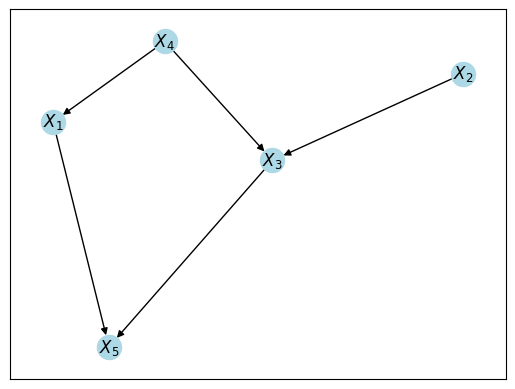

In [6]:
nx.draw_networkx(small_dag, pos=pos, node_color='lightblue')

Understanding the "complicated" density distribution on $\mathbb{R}^5$ now boils down to understand the simpler distributions:

$$f^G(x_1,\ldots,x_5):=f_{X_5|X_1, X_3}(x_5 | x_1, x_3)\cdot f_{X_3|X_2, X_4}(x_3|x_2, x_4)\cdot f_{X_1|X_4}(x_1|x_4)\cdot f_{X_4}(x_4)\cdot f_{X_2}(x_2)$$

## What can be done having such a Bayesian Network?

Having a Bayesian network for a system of jointly distributed random variables $X_1, \ldots, X_d$, a bunch of statistical questions about the data can be answered using properties of the DAG. For instance

* We can read off the DAG which variables are (in)dependent from each other (conditional independence statements)
* We can read off directions of influences and check long influence chains
* We find important variables that have a lot of influence onto others
* We can compare graphs for different datasets and find fundamental differences

## How to get a Bayesian network?

... say when $X_1, \ldots, X_d$ are some observable random variables and we want to understand the density function $f$ where $f(x_1, \ldots, x_d)$ is the likelihood of observing the incarnation $(x_1, \ldots, x_d)$.


### Questions to be answered

* What is `G`?
* What are the conditional distributions on the nodes of `G`?


Generally, we are the following (extreme) szenarious how to answer those questions:
* Option A: There exist experts who know exactly how the random variables relate to each other and they can just "write down" `G`  and all its conditional distributions
* Option B: Nobody has any clue but we have tons of observations and we can use the network using statistics and machine learning

Of course, there are also options in between :-). Nevertheless, lets discuss option B for the remainder

## Learning Bayesian Networks


### ... with known DAG

Assume we know `G`. Then we "just" have to learn the conditional functions $f_{X_i|P_G(X_i)}(\cdot|x_j: j\in P_G(i))$ from data, like by using parametrized probability models and using an maximum ilkelihood approach:


That is, given a parametrized family of functions $g^i_\theta:\mathbb{R}^{P(i)}\to\mathbb{R}$ for all $i\in [d]$ we want $\theta^*$ such that

$$g^i_{\theta^*}(x_j: j\in P_G(i)) \approx f_{X_i|P_G(X_i)}(\cdot|x_j: j\in P_G(i))$$


The `g^i`s can be learned using standard supervised learning methods.

#### Example

For instance, knowing that $X_3$ is depends on $X_1$ and $X_1$, we have to learn $ f_{X_3|X_1, X_2}(x_3|x_1, x_2)$. One valid approach might be the using a "naiive Bayes" model:

$$g^3_{\theta_1, \theta_2, \sigma}(x_1, x_2) =  \mathcal{N}(\theta_1\cdot x_1 + \theta_2 \cdot x_2, \sigma)$$


### ... with unkown DAG

Challenge here: A DAG is a mathematical object that cannot easily be parametrized, and hence optimization over it results into **NP-hard** problems.

But can we try them just all? Well, good luck, there are 
$$\sum_{k=1}^d(-1)^{k+1}\binom{d}{k}2^{k\cdot (d-k)}\cdot G(d-k)$$
many DAGs on $d$ nodes. Already for $d=10$: $4.2\cdot 10^{18}$ many DAGs. 

For high-dimensional data, like from manufacturing processes, we often have: $d=1000$ => We are f***ed :-)

There are some workarounds, but they all suffer from the curse of dimensionality and one cannot hope for convergence (in reasonable time).

## DAGs with NOTEARs


NOTEARs stands for ***N**on-combinatorial **O**ptimization via **T**race **E**xponential and **A**ugmented lag**r**angian for **S**tructure learning* (well, the name seems a bit doctored, right?) and the algorithm behind was first described in [arXiv:1803.01422](https://arxiv.org/abs/1803.01422). Lets start with the core idea and why there are no tears involved:

### Core idea

The basic idea is to reformulate the
combinatorial problem of finding a DAG for a problem to a continious
problem as follows: Let $x\in\mathbb{R}^d$. Assume that the function which describes the conditional distribution of $X_i$

$$g^i_\theta(x_1, \ldots,x_{i-1},x_{i+1}, \ldots, x_n)$$

gets **all other features** as input. Now, if for a certain parameter $\theta$, $g^i_\theta$ "does not depend on $x_j$", then $X_i$ does not depend on $X_j$.

* That means, there is no edge from $j$ to $i$ 


One can formalize the "does not depend on" by requiring the partial derivative 

$$\frac{\partial g_\theta^i}{\partial x_j}:\mathbb{R}^{d-1}\to\mathbb{R}^\mathbb{R}$$

to be the is the zero function (that is, zero for all elements of $\mathbb{R}^{d-1}$). 

**Note**: Mathematically correct, $g_\theta^i$ is a function into a function space. Its partial derivate is hence a bit more complicated to think about (lets say). Typically, the output of $g_\theta^i$ are parameters of a density function (not the density function itself), which makes a (huge) mathematical difference, but for most density functions seems to be fine (I think).

#### Example
For instance, if 

$$g^3_{\theta_1, \theta_2}(x_1, x_2) =  \left(x_3\mapsto \frac{1}{\sqrt{2\pi}}\cdot\exp{\left(\frac{(x_3 - (\theta_1x_1 + \theta_2x_2)}{2}\right)}\right)\in\mathbb{R}^\mathbb{R}$$

then $g^3_{\theta_1, \theta_2}$ does not depend on $x_1$ if and only if $\theta_1=0$

### An adjacency matrix
Now, define the parametrizd $d\times d$ matrix $W$ as

$$W(\theta)_{i,j}:=\left\|\frac{\partial g_\theta^i}{\partial x_j}\right\| $$

where $\|\cdot\|$ denotes a function norm, then

* there is no edge from $j$ to $i$ if $W(\theta)_{i,j}=0$.


That means, $W(\theta)$ encodes a graph on $\{X_1,\ldots, X_d\}$ for each parameter!

So what have we won? Actually, nothing so far. The magic now comes from the following result (see Theorem 1 in [arXiv:1803.01422](https://arxiv.org/abs/1803.01422)):


   **Lemma:** A directed graph with adjacency matrix $W\in\mathbb{R}^{d\times d}$ is acyclic if and only if
   $\text{trace}\left(\exp(W)\right)=d$.

Lets check that for our `small_dag`

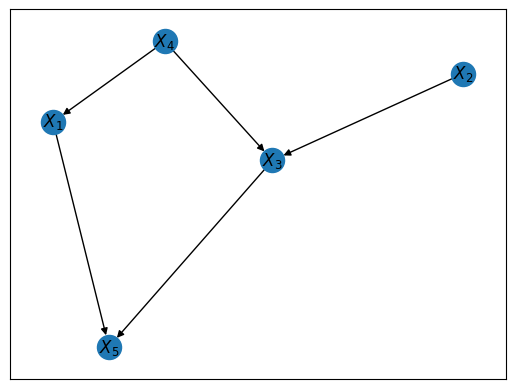

In [7]:
nx.draw_networkx(small_dag, pos=pos)

In [8]:
W = nx.convert_matrix.to_numpy_matrix(small_dag)
W

matrix([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [9]:
from scipy.linalg import expm

In [10]:
expm(W)

array([[1. , 1. , 0. , 0. , 0.5],
       [0. , 1. , 0. , 0. , 1. ],
       [0. , 1. , 1. , 1. , 1. ],
       [0. , 0. , 0. , 1. , 1. ],
       [0. , 0. , 0. , 0. , 1. ]])

In [11]:
np.trace(expm(W)) - 5.0

0.0

So, no cycle in `small_graph`!

### Optimization problem of NOTEARs

Ok, to put everything together, we have to solve the following **continiuous** optimization problem:

$$\underbrace{\min_{\theta\in\Theta}\sum_{x\in D}-\sum_{i=1}^d \log g^i_{\theta_i}(x_1, \ldots,x_{i-1},x_{i+1}, \ldots, x_n)(x_i)}_{\text{minimize negative log-likelihood}}\quad\text{ such that }\quad\text{trace}\left(\exp(W(\theta))\right)-d=0$$

### Linear node models

In case all $g^i_{\theta_i}$ are naive base models with additive mean, we can write down $W$ directly:


$$W(\theta_1, \ldots, \theta_d)=\begin{pmatrix}\cdots\theta_1\cdots \\ \vdots \\ \cdots\theta_d\cdots\end{pmatrix}\in\mathbb{R}^{d\times d}$$

More details can be found in the [NOTEARs paper](https://arxiv.org/abs/1803.01422)

### More flexible node models

As dependences between $X_i$ and its (true) parents can be arbitrarily compilcated, we need arbitrarily flexible functions to approximate the conditional distribution (aka Neural nets).

We choose each $g^i_\theta$ to be a [Mixture density networks](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf), that is a neural network which assumes the conditional distribution of $X_i$ to be a mixture of gaussian distributions

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Gaussian-mixture-example.svg/320px-Gaussian-mixture-example.svg.png">
</div>

Particularly, the output of $g^i_\theta$ for any $(x_1, \ldots,x_{i-1},x_{i+1}, \ldots, x_n)$ are the parameters the mixture model for $X_i$:

<br />

<div>
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0890540121001048-gr004.jpg">
</div>

(figure taken from [here](https://www.sciencedirect.com/science/article/pii/S0890540121001048))

...mhh..wait a bit: What is $\frac{\partial g_\theta^i}{\partial x_j}$ when $g_\theta^i$ is a neural net?


Its (computationally) infeasible to compute (symbolically) the deriviate of a neural network and hence we have to look for sufficient (and hence stronger) conditions that imply that the partial derivative is zero. Here are two ideas:

* If the weights of the first layer that get multiplied with $x_j$ are all zero, then certainly the derivate is zero (this is published in [Learning Sparse Nonparametric DAGs](https://arxiv.org/abs/1909.13189)
* Analyse the connectivity in the neural network, more specifically: check whether the values of $x_j$ reach the final layer (this is from [Gradient-Based Neural DAG Learning](https://arxiv.org/abs/1906.02226)

### One question remains!

How to train neural networks so that their parameters satisfy certain quality constraints?

Answer: Use the [augmented lagrangian method](https://en.wikipedia.org/wiki/Augmented_Lagrangian_method)

$$\min_{\theta\in\Theta} g(\theta) \quad\text{ such that }\quad h(\theta)=0$$

   
by solving a series of unconstrained optimization problems that add a
pentalty term to the original problem. 
As in our case, $h$ maps to a one-dimensional space, the
augmented lagrangian method for this simplified version is as follows,
the $k$-th problem looks as folllows:

$$\min_{\theta\in\Theta}\left(g(\theta) + \frac{\rho_k}{2}\cdot h(\theta)^2 + \alpha_k\cdot h(\theta)\right)$$
   
Where $\rho_{k+1}=C\cdot\rho_k$ and $\alpha_{k+1} =
\alpha_k + \rho_k\cdot h(\theta_k)$, $\theta_k$ is the solution
to the $k$-th optimization problem.

## Causal Discovery solved?

There is still a lot work to do:
* [Causal discovery benchmarks may be too easy to game](https://arxiv.org/abs/2102.13647)
* [NOTEARs struggles with dimension quantities](https://link.springer.com/article/10.1007/s11063-021-10694-5)

### Large cycles are ignored!

In [12]:
def get_adjacency_of_cycle(length):
    return nx.to_numpy_array(nx.cycle_graph(length, create_using=nx.DiGraph))

In [13]:
W5 = get_adjacency_of_cycle(5)
W10 = get_adjacency_of_cycle(10)
W20 = get_adjacency_of_cycle(20)

In [14]:
np.trace(expm(W5))-5 == 0

False

In [15]:
np.trace(expm(W10))-10 == 0

False

In [16]:
np.trace(expm(W20))-20 == 0

True

**WTF?!**

$$\text{exp}(W)=1+\sum_{i=1}^\infty\frac{W^k}{k!}$$

In [17]:
np.diag(expm(W20))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [18]:
from scipy.special import factorial

In [19]:
1+1/factorial(20) == 1

True

Trace of matrix exponent may not be good choice in practice! Other works, like NOBEARs use spectral information of the adjacency instead (like the largest eigenvalue).

### Many hparams and no out-of-the-box usage

In [19]:
from bn_testing.models import BayesianNetwork
from bn_testing.dags import ErdosReny
from bn_testing.conditionals import PolynomialConditional
from bn_testing.conditionals import LinearConditional
import pymc as pm

In [50]:
class SimpleConditional(LinearConditional):

    def make_source(self):
        return pm.Beta.dist(
            alpha=self.random.uniform(1, 5),
            beta=self.random.uniform(1, 5),
        )
        
    def make_noise(self):
        return pm.Beta.dist(
            alpha=self.random.uniform(1, 5),
            beta=self.random.uniform(1, 5),
        )

In [51]:
model = BayesianNetwork(
    dag=ErdosReny(n_visible_nodes=20, p=0.15),
    conditionals=SimpleConditional(),
    random_state=10,
)

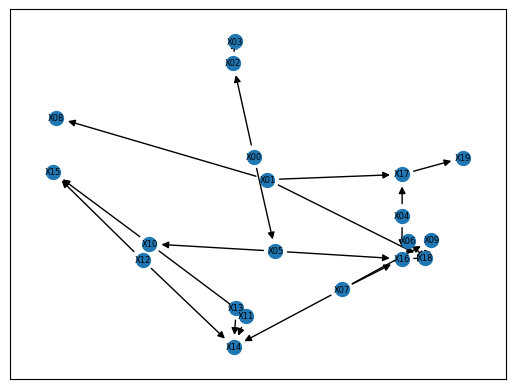

In [52]:
model.show()

In [53]:
df = model.sample(2000, normalize=True)

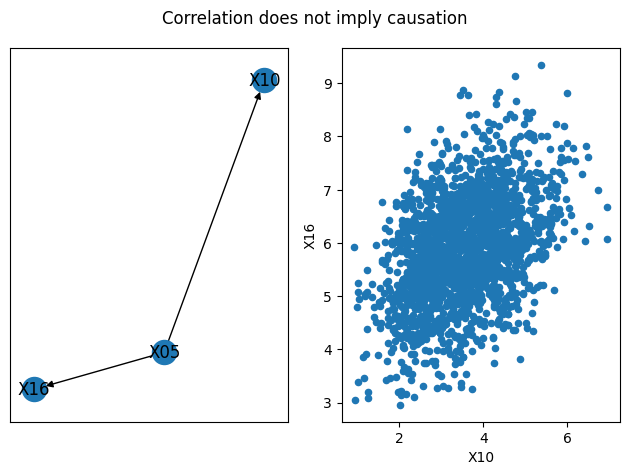

In [54]:
fig, axes = plt.subplots(ncols=2)

df.plot.scatter(x='X10', y='X16', ax=axes[1])

nx.draw_networkx(model.dag.subgraph(['X05', 'X10', 'X16']), ax=axes[0])
fig.suptitle('Correlation does not imply causation')
fig.tight_layout()

In [55]:
from causalnex.structure.notears import from_pandas

In [67]:
dag_learned = from_pandas(df, w_threshold=0.3, max_iter=200)

Text(0.5, 1.0, 'Learned')

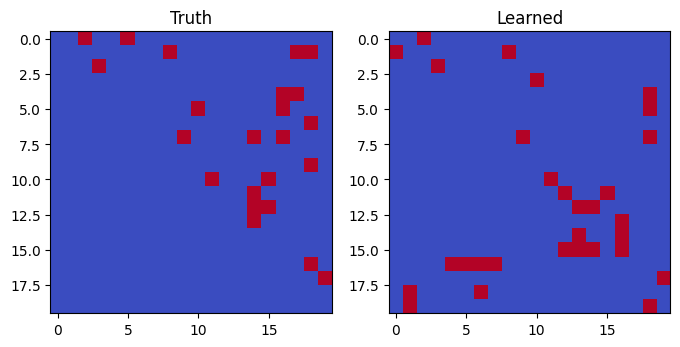

In [74]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

axes[0].imshow(nx.to_numpy_array(model.dag), cmap='coolwarm')
axes[0].set_title('Truth')

axes[1].imshow(nx.to_numpy_array(dag_learned) != 0, cmap='coolwarm')
axes[1].set_title('Learned')

And here the result of a method customized to this setting: [LINGAM](https://lingam.readthedocs.io/en/latest/tutorial/lingam.html#id5), a method to learn a linear, non-gaussian structural equation model (LINGAM)

In [70]:
import lingam

In [71]:
model_lingam = lingam.DirectLiNGAM()
model_lingam.fit(df)

Text(0.5, 1.0, 'Learned')

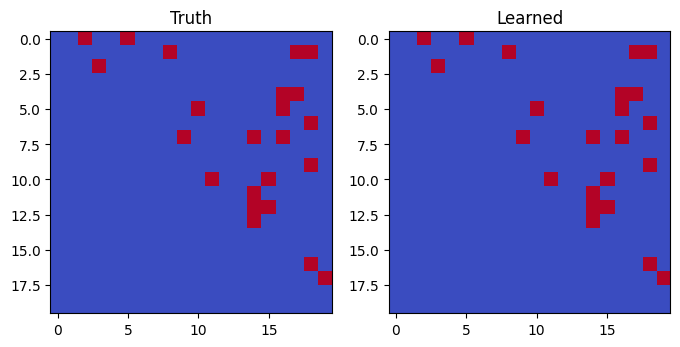

In [73]:
fig, axes = plt.subplots(figsize=(8, 4), ncols=2)

axes[0].imshow(nx.to_numpy_array(model.dag), cmap='coolwarm')
axes[0].set_title('Truth')

axes[1].imshow(model_lingam.adjacency_matrix_.T != 0, cmap='coolwarm')
axes[1].set_title('Learned')